In [1]:
import torch as th 
import numpy as np 

### Question 3.1: Programming warmup 

#### 3.1.1 Regularization

In [2]:
# global n (tensor-size) variable 
n=5

In [3]:
tensor = th.rand(n, n)

def change_diagonals(c, a):
    # c must be square
    digonal_incdicies = th.arange(min(c.shape))

    # indexes the tensor using the diagonal indices and add each element by a 
    c[digonal_incdicies, digonal_incdicies] += a

    return c

regularized_tensor = change_diagonals(tensor, 10)
print(regularized_tensor)

tensor([[10.4445,  0.6124,  0.9821,  0.3001,  0.7548],
        [ 0.7155, 10.1304,  0.5664,  0.6764,  0.6377],
        [ 0.1827,  0.0952, 10.0167,  0.4224,  0.5774],
        [ 0.6939,  0.2657,  0.2036, 10.7238,  0.1723],
        [ 0.3845,  0.8623,  0.7890,  0.5564, 10.2578]])


#### 3.1.2 Largest Off-diagonal Element

In [4]:
tensor = th.rand(n, n)

def largest_off_diag(a):
    # th.eye(n, dtype=th.bool) creates a masking matrix along the diagonal (1) and 0 elsewhere
    # ~ inverts this 
    mask = ~th.eye(n, dtype=th.bool)

    # indexes the tensor using the max to access everything EXCEPT the diagonals 
    return a[mask].max()

print(tensor)
print(largest_off_diag(tensor))

tensor([[0.9238, 0.0240, 0.3827, 0.7248, 0.1697],
        [0.5444, 0.6691, 0.1849, 0.7756, 0.7352],
        [0.8990, 0.5571, 0.3188, 0.0715, 0.7051],
        [0.8809, 0.2001, 0.0397, 0.0722, 0.2808],
        [0.3189, 0.7091, 0.9925, 0.2210, 0.9972]])
tensor(0.9925)


#### 3.1.3 Chess Players

In [5]:
players = [i for i in range (16)]

### 3.2 CLIP

#### 3.2.1 Loading the pre-trained CLIP model 

In [6]:
from transformers import CLIPModel

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")


2025-09-03 21:40:26.994218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 21:40:27.221413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756950027.305573    6049 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756950027.335234    6049 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756950027.524413    6049 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
total_params = sum(p.numel() for p in clip.parameters())

print(f"Total parameters in CLIP is {total_params}")

Total parameters in CLIP is 149620737


#### 3.2.2 Loading the SVHN Dataset

In [8]:
# loading training and test
import tensorflow_datasets as TFDS 
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# transforming dataset into tensors to be scriptable later
transform = transforms.Compose([
    transforms.ToTensor(),  # CHW, float32
])

train = datasets.SVHN("svhn_cropped", split="train",  transform = transform, download=True)
test = datasets.SVHN("svhn_cropped", split="test", transform = transform, download=True)

Using downloaded and verified file: svhn_cropped/train_32x32.mat
Using downloaded and verified file: svhn_cropped/test_32x32.mat


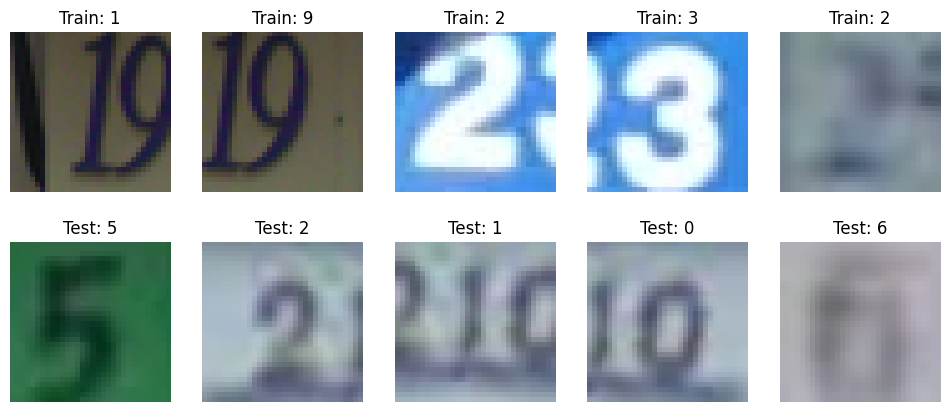

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    img, label = train[i]
    axes[0, i].imshow(img.permute(1, 2, 0))  # CHW -> HWC
    axes[0, i].set_title(f"Train: {label}")
    axes[0, i].axis("off")

    img, label = test[i]
    axes[1, i].imshow(img.permute(1, 2, 0))
    axes[1, i].set_title(f"Test: {label}")
    axes[1, i].axis("off")

plt.show()    

#### 3.2.3 Freezing CLIP and training a classifier 

For this question, we will be using a two layer feed forward neural network with a relu activation function in between as a classifier for the image embeddings outputted from CLIP

In [10]:
# getting the image embeddings dimension of clip for the first dimension (row wise) of the first layer 
print(clip.projection_dim)

512


In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ClipClassifier(nn.Module):
    def __init__(self, n, clip_model):
        super().__init__()
        self.layer1 = nn.Linear(512, n)
        self.layer2 = nn.Linear(n, 10) #number of classes (0-9)
        self.clip = clip_model
        
        # Freeze CLIP parameters
        for param in self.clip.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Use CLIP's vision model to get image embeddings
        with th.no_grad(): #no grad updates for the clip model
            vision_outputs = self.clip.vision_model(pixel_values=x)
            embeddings = self.clip.visual_projection(vision_outputs.pooler_output)
        
        # Pass through our  classifier layers
        x = F.relu(self.layer1(embeddings))
        return self.layer2(x)
    

#### defining variables pre-train loop

In [12]:
from torch.utils.data import DataLoader
from PIL import Image
from transformers import CLIPProcessor

# Load the CLIP processor for proper image preprocessing
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

def collate_fn(batch):
    imgs, labels = zip(*batch)
    # Convert PyTorch tensors to PIL images (need to denormalize and convert to uint8)
    imgs_pil = []
    for img in imgs:
        # Convert from CHW to HWC and scale to 0-255
        img_np = (img.permute(1, 2, 0).numpy() * 255).astype('uint8')
        imgs_pil.append(Image.fromarray(img_np))
    
    # Use CLIP processor for proper preprocessing
    inputs = processor(images=imgs_pil, return_tensors="pt")
    return inputs["pixel_values"], th.tensor(labels)

train_loader = DataLoader(train, 64, True, collate_fn=collate_fn) 
test_loader = DataLoader(test, 64, False, collate_fn=collate_fn)
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = ClipClassifier(256, clip) #init device
model.to(device)
criterion = nn.CrossEntropyLoss() #cross entropy loss for classification task
optimizer = optim.Adam(model.parameters(), 0.001) #adam optimizer

In [13]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with th.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return test_loss, accuracy


In [14]:
# Main training loop
num_epochs = 5
print(f"Training on device: {device}")
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters")

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 20)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

print('\nTraining completed!')


Training on device: cpu
Model has 133898 trainable parameters

Epoch 1/5
--------------------
Batch 0/1145, Loss: 2.322683


KeyboardInterrupt: 